Useful reference: https://stackoverflow.com/questions/59182827/how-to-get-the-cells-of-a-sudoku-grid-with-opencv

In [1]:
import os

os.getcwd()

'c:\\Users\\barto\\Documents\\DS2024Z\\ISR\\ISR-2024W-SudokuSolver'

In [2]:
import numpy as np
from pathlib import Path

DATA = Path("../data")
DATA

WindowsPath('../data')

In [ ]:
from tests.full_test import read_sudoku_from_dat

In [4]:
read_sudoku_from_dat(r"data\sudoku_dataset\v1_test\v1_test\image8.dat")

array([[0, 0, 0, 7, 0, 0, 0, 8, 0],
       [0, 9, 0, 0, 0, 3, 1, 0, 0],
       [0, 0, 6, 8, 0, 5, 0, 7, 0],
       [0, 2, 0, 6, 0, 0, 0, 4, 9],
       [0, 0, 0, 2, 0, 0, 0, 5, 0],
       [0, 0, 8, 0, 4, 0, 0, 0, 7],
       [0, 0, 0, 9, 0, 0, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 0, 0, 6],
       [1, 0, 5, 0, 0, 4, 0, 0, 0]])

# Image Processing

In [5]:
import random

def choose_random_jpg(data_path):
    jpg_files = list(data_path.rglob('*.jpg'))
    if not jpg_files:
        return None
    return random.choice(jpg_files)

random_jpg = choose_random_jpg(Path("data/sudoku_dataset"))
print(random_jpg)

data\sudoku_dataset\v1_training\v1_training\image10.jpg


In [6]:
import cv2

In [7]:
# load and convert to grayscale
image = cv2.imread(str(random_jpg))
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

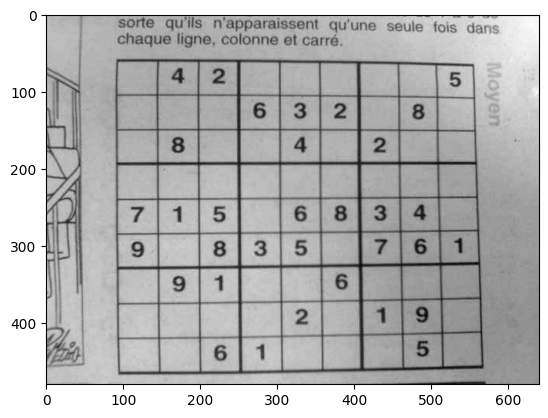

In [8]:
import cv2
import matplotlib.pyplot as plt
plt.imshow(gray_img, cmap='gray')
plt.show()

Adaptive thresholding: 
- https://www.youtube.com/watch?v=UFWLkN5dIpQ
- https://homepages.inf.ed.ac.uk/rbf/HIPR2/adpthrsh.htm#:~:text=Adaptive%20thresholding%20typically%20takes%20a,threshold%20has%20to%20be%20calculated.

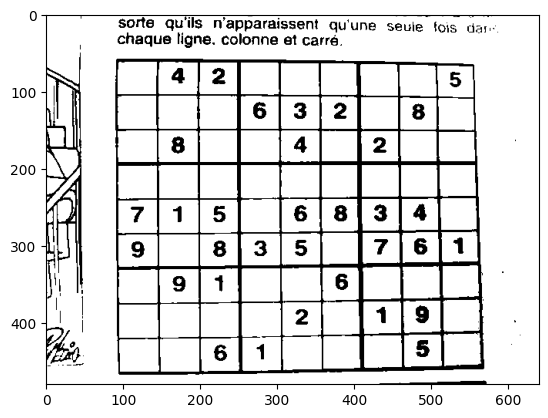

In [98]:
# perform otsu binarization

_, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(binary, cmap='gray')
plt.show()

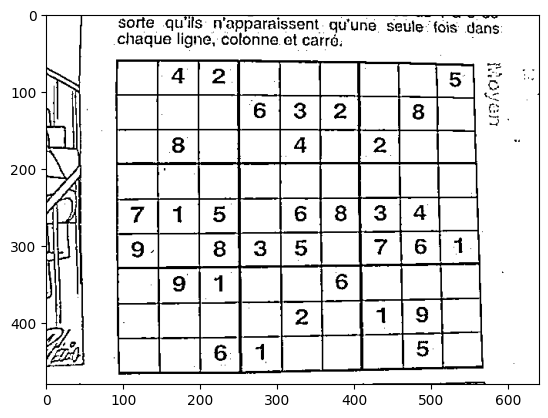

In [164]:
# apply adaptive thresholding
binary = cv2.adaptiveThreshold(
    gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 6
)
# invert the image
binary = cv2.bitwise_not(binary)

plt.imshow(binary, cmap='gray')
plt.show()

In [165]:
# find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

36


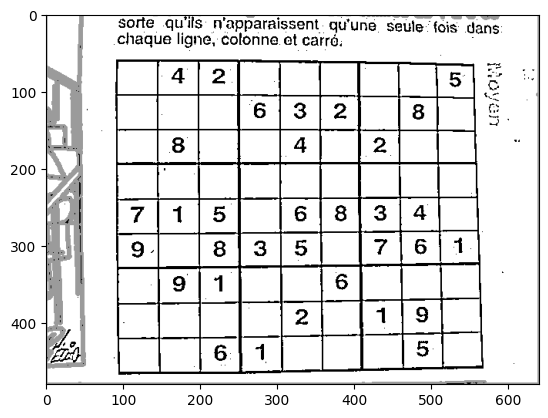

In [166]:
# draw the contours on the original image
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
contour_img = cv2.drawContours(binary.copy(), contours, -1, (155, 255, 0), 2)
plt.imshow(contour_img, cmap='gray')
plt.show()

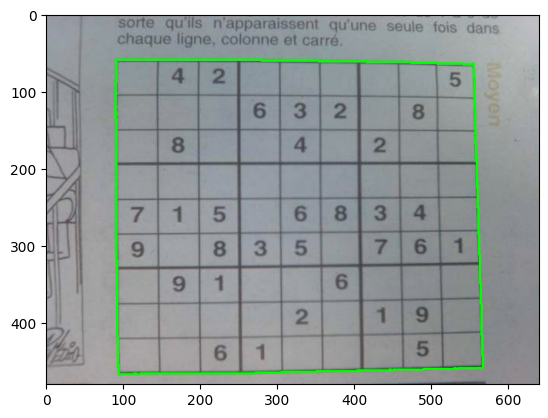

In [170]:
# apply adaptive thresholding
binary = cv2.adaptiveThreshold(
    gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 5
)
# _, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# show contours on the original image with green color and thickness of 2
# contour_img = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 2)

# fidn the largest contour (assumed to be the Sudoku grid)
largest_contour = max(contours, key=cv2.contourArea)

# show the largest contour
contour_img = cv2.drawContours(image.copy(), [largest_contour], -1, (0, 255, 0), 2)

plt.imshow(contour_img)

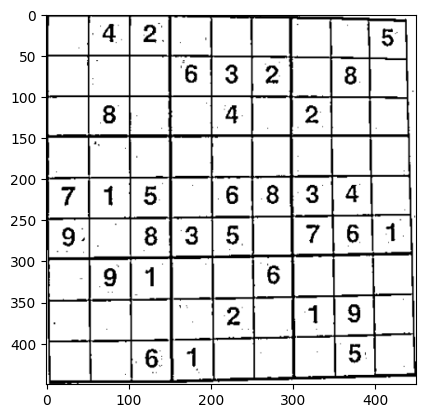

In [171]:
# bounding box of the largest contour
x, y, w, h = cv2.boundingRect(largest_contour)

# warp the image to straighten the grid
pts1 = np.float32([[x, y], [x + w, y], [x, y + h], [x + w, y + h]])
pts2 = np.float32([[0, 0], [450, 0], [0, 450], [450, 450]])  # Standard size
matrix = cv2.getPerspectiveTransform(pts1, pts2)
warped = cv2.warpPerspective(binary, matrix, (450, 450))


warped_viz = cv2.bitwise_not(warped)
# visualize the warped image
plt.imshow(warped_viz, cmap='gray')

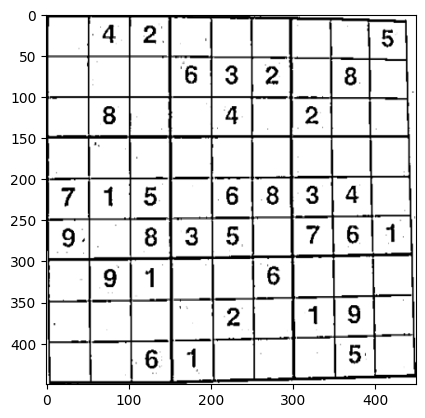

In [172]:
opening = cv2.morphologyEx(warped, cv2.MORPH_OPEN, kernel=(3, 3), iterations=1)
opening = cv2.bitwise_not(opening)
plt.imshow(opening, cmap='gray')

In [176]:
import os
cell_height, cell_width = opening.shape[0] // 9, opening.shape[1] // 9
cells = []
for i in range(9):
    row = []
    for j in range(9):
        x, y = j * cell_width, i * cell_height
        cell = opening[y:y + cell_height, x:x + cell_width]
        row.append(cell)
    cells.append(row)

def save_cells_as_images(cells, output_dir):
    """Save individual cells as images in a specified directory."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i, row in enumerate(cells):
        for j, cell in enumerate(row):
            cell_path = os.path.join(output_dir, f"cell_{i}_{j}.png")
            cv2.imwrite(cell_path, cell)

In [177]:
save_cells_as_images(cells, "data/output")

In [178]:
def plot_original_and_cells(original_image, cells):
    """Plot the original image and extracted cells side by side, with separated cell borders and green borders around each cell."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the original image
    axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Create a blank canvas for the cells with spacing between them
    cell_height, cell_width = cells[0][0].shape
    spacing = 5  # Spacing between cells
    border_thickness = 2  # Thickness of the green border
    canvas_height = 9 * (cell_height + 2 * border_thickness) + 8 * spacing
    canvas_width = 9 * (cell_width + 2 * border_thickness) + 8 * spacing
    canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255  # White background

    for i in range(9):
        for j in range(9):
            y_start = i * (cell_height + 2 * border_thickness + spacing)
            y_end = y_start + cell_height + 2 * border_thickness
            x_start = j * (cell_width + 2 * border_thickness + spacing)
            x_end = x_start + cell_width + 2 * border_thickness

            # Draw the green border
            canvas[y_start:y_end, x_start:x_end] = [0, 255, 0]  # Green border

            # Place the cell inside the border
            canvas[y_start + border_thickness:y_end - border_thickness,
                   x_start + border_thickness:x_end - border_thickness] = cv2.cvtColor(cells[i][j], cv2.COLOR_GRAY2BGR)

    # Plot the separated cells
    axes[1].imshow(canvas)
    axes[1].set_title("Extracted Cells")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

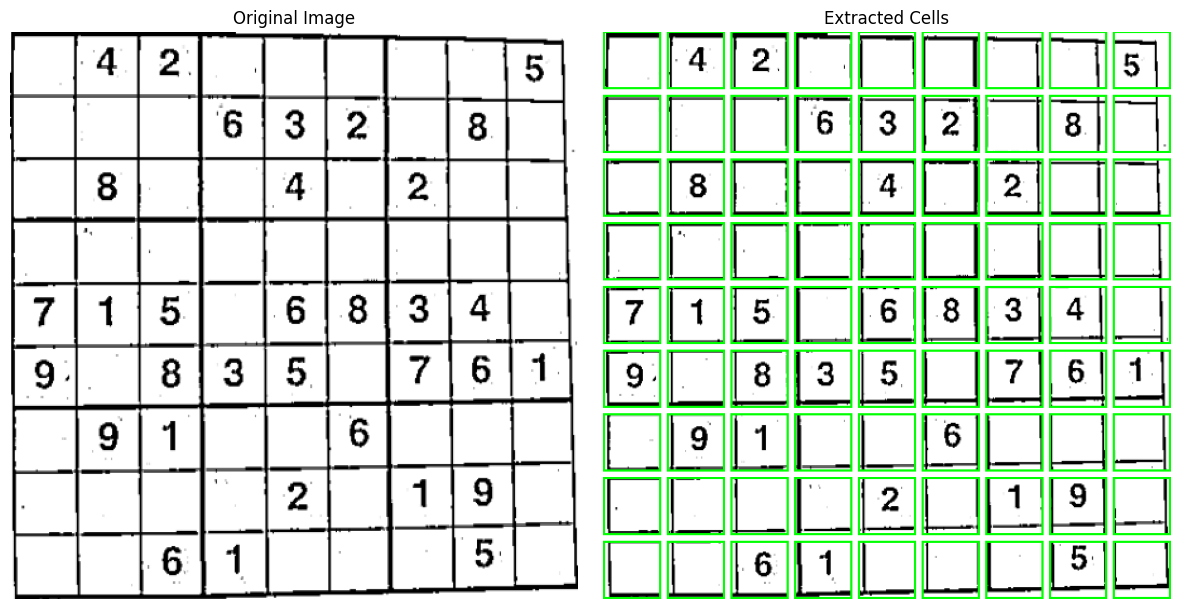

In [179]:
plot_original_and_cells(opening, cells)

In [180]:
exp_board = read_sudoku_from_dat(r"data\sudoku_dataset\v1_training\v1_training\image10.dat")

In [181]:
# for each of the cell, print the expected digit, and the avg pixel value
digit_cells = []
nondigit_cells = []

for i, row in enumerate(cells):
    for j, cell in enumerate(row):
        avg_pixel_value = cell.mean()
        print(f"Cell ({i}, {j}): Expected digit: {exp_board[i][j]}, Avg Pixel Value: {avg_pixel_value}")
        if exp_board[i][j] == 0:
            nondigit_cells.append(avg_pixel_value)
        else:
            digit_cells.append(avg_pixel_value)

print(f"Average pixel value for digit cells: {np.mean(digit_cells)}")
print(f"Average pixel value for non-digit cells: {np.mean(nondigit_cells)}")

Cell (0, 0): Expected digit: 0, Avg Pixel Value: 222.036
Cell (0, 1): Expected digit: 4, Avg Pixel Value: 208.368
Cell (0, 2): Expected digit: 2, Avg Pixel Value: 200.1992
Cell (0, 3): Expected digit: 0, Avg Pixel Value: 220.2156
Cell (0, 4): Expected digit: 0, Avg Pixel Value: 220.5668
Cell (0, 5): Expected digit: 0, Avg Pixel Value: 215.2904
Cell (0, 6): Expected digit: 0, Avg Pixel Value: 228.21
Cell (0, 7): Expected digit: 0, Avg Pixel Value: 228.6252
Cell (0, 8): Expected digit: 5, Avg Pixel Value: 217.7324
Cell (1, 0): Expected digit: 0, Avg Pixel Value: 233.224
Cell (1, 1): Expected digit: 0, Avg Pixel Value: 235.3756
Cell (1, 2): Expected digit: 0, Avg Pixel Value: 230.3924
Cell (1, 3): Expected digit: 6, Avg Pixel Value: 208.8632
Cell (1, 4): Expected digit: 3, Avg Pixel Value: 215.1436
Cell (1, 5): Expected digit: 2, Avg Pixel Value: 200.6876
Cell (1, 6): Expected digit: 0, Avg Pixel Value: 230.318
Cell (1, 7): Expected digit: 8, Avg Pixel Value: 212.3724
Cell (1, 8): Expecte

**Comment**: Avg pixel intensity threshold is NOT an effective way to recognize digit cells from non-digit cells

In [185]:
def has_significant_components(cell):
    """Check for significant connected components."""
    _, _, stats, _ = cv2.connectedComponentsWithStats(cell)
    for stat in stats[1:]:  # Ignore the background
        # print(stat[cv2.CC_STAT_AREA])
        if stat[cv2.CC_STAT_AREA] > 500:  # Adjust area threshold
            return True
    return False

acc = 0
for i, row in enumerate(cells):
    for j, cell in enumerate(row):
        if has_significant_components(cell):
            if exp_board[i][j] != 0:
                acc += 1
        else:
            if exp_board[i][j] == 0:
                acc += 1
print(acc/81)

0.4074074074074074


**Comment**: Significant componetns analysis is NOT an effective way to recognize digit cells from non-digit cells

In [183]:
from predict_digit_easy_ocr import predict_single_image

OCR is time-consuming! ~2.5mins for 81 digit images....

IDEA: do not consider pics with too low avg/total pixel intensity...

In [184]:
import numpy as np
from tqdm import tqdm

board = np.zeros((9, 9), dtype=int)
progress_bar = tqdm(total=81, desc="Recognizing cells")
for i, row in enumerate(cells):
    for j, cell in enumerate(row):
        prediction = predict_single_image(cell)
        board[i][j] = prediction if prediction in map(str, range(1, 10)) else 0
        progress_bar.update(1)
progress_bar.close()

Recognizing cells: 100%|██████████| 81/81 [02:28<00:00,  1.84s/it]


In [186]:
def recognize_board(cells, empty_threshold=50):
    """Recognize digits from cells and fill the board with predictions."""
    board = np.zeros((9, 9), dtype=int)
    progress_bar = tqdm(total=81, desc="Recognizing cells")
    for i, row in enumerate(cells):
        for j, cell in enumerate(row):
            mean_intensity = np.mean(cell)
            if mean_intensity > empty_threshold:
                board[i][j] = 0
            else:
                prediction = predict_single_image(cell)
                board[i][j] = prediction if prediction in map(str, range(1, 10)) else 0

            progress_bar.update(1)

    progress_bar.close()
    return board

In [188]:
recognized_board = recognize_board(cells, empty_threshold=70)
recognized_board

Recognizing cells: 100%|██████████| 81/81 [00:00<00:00, 80506.78it/s]


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [189]:
board

array([[0, 0, 2, 0, 0, 0, 0, 0, 5],
       [0, 0, 0, 0, 0, 2, 0, 8, 0],
       [0, 8, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 3, 0, 0],
       [9, 0, 8, 3, 5, 0, 0, 6, 0],
       [0, 9, 0, 0, 0, 6, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 9, 0],
       [0, 0, 6, 0, 0, 0, 0, 5, 0]])

In [190]:
exp_board = read_sudoku_from_dat(r"data\sudoku_dataset\v1_training\v1_training\image10.dat")
exp_board

array([[0, 4, 2, 0, 0, 0, 0, 0, 5],
       [0, 0, 0, 6, 3, 2, 0, 8, 0],
       [0, 8, 0, 0, 4, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [7, 1, 5, 0, 6, 8, 3, 4, 0],
       [9, 0, 8, 3, 5, 0, 7, 6, 1],
       [0, 9, 1, 0, 0, 6, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 1, 9, 0],
       [0, 0, 6, 1, 0, 0, 0, 5, 0]])

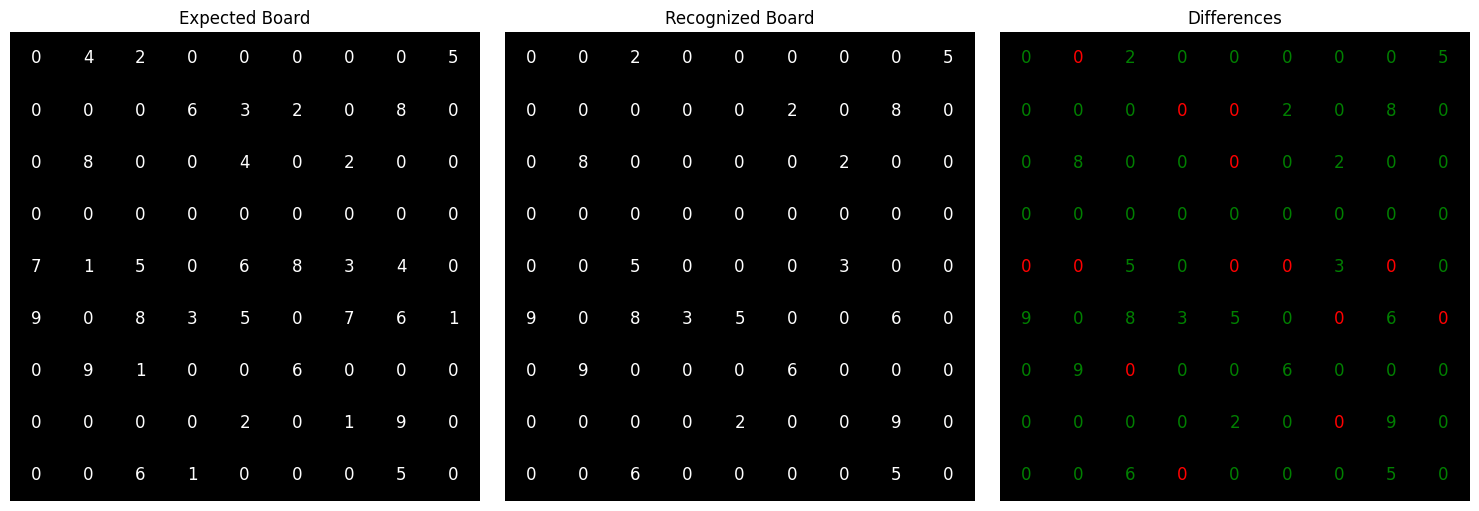

In [191]:
def plot_boards(expected_board, recognized_board):
    """Plot the expected board, recognized board, and their differences side by side with colors."""
    _, axes = plt.subplots(1, 3, figsize=(15, 5))

    color_dict = {
        0: "green",
        1: "orange",
        2: "red"
    }

    # function to plot a board with colors for differences
    def plot_board(ax, board, title, differences=None):
        ax.imshow(np.zeros((9, 9)), cmap="gray")
        for i in range(9):
            for j in range(9):
                value = board[i, j]
                if differences is None: 
                    color = "white"
                else:
                    color = color_dict[differences[i, j]]
                ax.text(j, i, str(value), ha='center', va='center', color=color, fontsize=12)
        ax.set_title(title)
        ax.axis("off")

    differences = np.zeros_like(expected_board, dtype=int)
    for i in range(9):
        for j in range(9):
            if expected_board[i, j] == 0 and recognized_board[i, j] == 0:
                differences[i, j] = 0  # correct no recognition
            elif expected_board[i, j] == recognized_board[i, j]:
                differences[i, j] = 0  # correct 
            elif expected_board[i, j] in range(1, 10):
                differences[i, j] = 2  # missing recognition
            else:
                differences[i, j] = 1  # incorrect match
    plot_board(axes[0], expected_board, "Expected Board")
    plot_board(axes[1], recognized_board, "Recognized Board")
    plot_board(axes[2], recognized_board, "Differences", differences=differences)

    plt.tight_layout()
    plt.show()

plot_boards(exp_board, board)


In [192]:
def compute_recognition_metrics(expected_board, recognized_board):
    total_digits = 81
    correct_recognition = 0
    not_recognized = 0
    misrecognized = 0

    for i in range(9):
        for j in range(9):
            expected = expected_board[i, j]
            recognized = recognized_board[i, j]

            if expected == recognized:
                correct_recognition += 1
            elif expected != 0 and recognized == 0:
                not_recognized += 1
            elif expected != recognized and recognized != 0:
                misrecognized += 1

    return {
        "Correctly Recognized (%)": (correct_recognition / total_digits) * 100,
        "Not Recognized (%)": (not_recognized / total_digits) * 100,
        "Misrecognized Digits (%)": (misrecognized / total_digits) * 100,
    }

In [193]:
compute_recognition_metrics(exp_board, board)

{'Correctly Recognized (%)': 82.71604938271605,
 'Not Recognized (%)': 17.28395061728395,
 'Misrecognized Digits (%)': 0.0}

### Improving digit recognition through OCR

IDEA: remove image borders by:
1) recognizing horizontal and vertical edges of length almost eg. 90% of the whole window (cell) length or width, OR
2) cropping by a fixed value

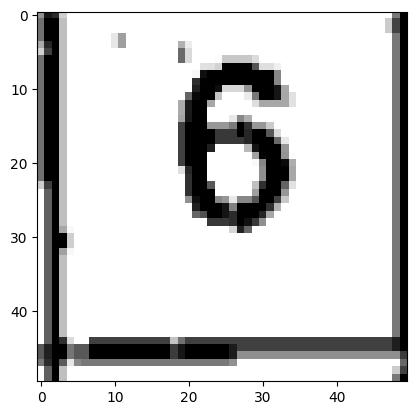

In [197]:
six_img = cells[6][5]

plt.imshow(six_img, cmap='gray')

(50, 50) (42, 42)


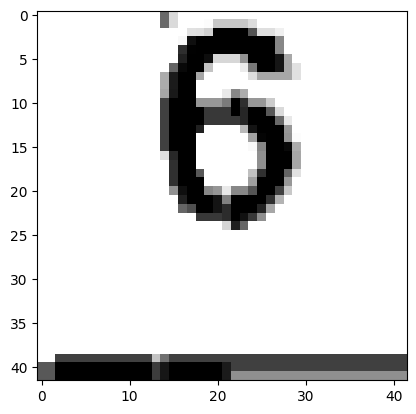

In [208]:

# apply to six_img
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
eroded = cv2.erode(six_img, kernel, iterations=1)
h, w = eroded.shape
cropped = eroded[5:h-3, 5:w-3]  # Adjust crop size as needed
plt.imshow(cropped, cmap='gray')

print(six_img.shape, cropped.shape)